#### Etapa Final: Implementación y Comparación de Modelos de Clasificación

En esta etapa final del proyecto se procede a la implementación de modelos de clasificación, con el propósito de evaluar el efecto de la reducción de dimensionalidad sobre el desempeño predictivo y la estructura del problema. Las fases de proyecto son las siguientes:

En primer lugar, se construyen dos modelos de clasificación utilizando el conjunto de datos original, es decir, considerando la totalidad de las variables explicativas sin aplicar técnicas de reducción de dimensionalidad. Esta aproximación permite establecer una línea base (baseline) para el análisis comparativo posterior.
Posteriormente, se desarrollan los mismos modelos de clasificación empleando como variables de entrada las componentes principales obtenidas en la etapa de reducción de dimensionalidad mediante PCA. De esta forma, se evalúa si la representación reducida de los datos logra preservar información relevante para la tarea de clasificación.
Ambos enfoques se implementan bajo condiciones metodológicas comparables, manteniendo criterios consistentes de partición de datos y métricas de evaluación. El desempeño de los modelos se analiza mediante indicadores adecuados al problema de clasificación, permitiendo contrastar los resultados obtenidos con datos originales y con datos reducidos.

Finalmente, se realiza un análisis comparativo de los resultados, discutiendo las ventajas y limitaciones de cada enfoque, así como el impacto del uso de PCA en términos de desempeño, interpretabilidad y complejidad del modelo. Esta etapa cierra el proyecto integrando los aprendizajes obtenidos a lo largo de las fases previas y fundamentando las decisiones analíticas adoptadas.



# Plan:
* **Reconstruir y preprocesar datos**: Reconstruir el DataFrame `df_wb_raw` volviendo a descargar los datos de la API del Banco Mundial, aplicando los pasos de gestión de datos faltantes (eliminar columnas con >=15% de valores faltantes, imputar valores numéricos con mediana) y discretizar la variable objetivo `NY.GDP.MKTP.PP.KD`. Esto garantiza la independencia de los datos.
* **Preparar el conjunto de datos original para el modelado**: A partir del `df_wb_raw` preprocesado, separar las características (X_original) y la variable objetivo (y). Estandarizar las características numéricas en `X_original`. Dividir `X_original` e `y` en conjuntos de entrenamiento y prueba (`X_original_train`, `X_original_test`, `y_original_train`, `y_original_test`) mediante estratificación.
* **Preparar el conjunto de datos de PCA para el modelado**: Volver a aplicar el PCA a las características numéricas estandarizadas de `df_wb_raw` para obtener el DataFrame `df_pca` con el número seleccionado (7 componentes que explican aproximadamente el 82,51 % de la varianza). Separar las características (X_pca) y la variable objetivo (y). Dividir `X_pca` e `y` en conjuntos de entrenamiento y prueba (`X_pca_train`, `X_pca_test`, `y_pca_train`, `y_pca_test`) mediante estratificación.
* **Implementar y evaluar modelos (datos originales)**: Entrenar modelos de regresión logística y Random Forest utilizando `X_original_train` e `y_original_train`. Evalúe su rendimiento en `X_original_test` e `y_original_test` utilizando precisión, informes de clasificación y matrices de confusión. Todos los comentarios deben estar en español.
* **Implementar y evaluar modelos (datos PCA)**: Entrene modelos de regresión logística y Random Forest utilizando `X_pca_train` e `y_pca_train`. Evalúe su rendimiento en `X_pca_test` e `y_pca_test` utilizando precisión, informes de clasificación y matrices de confusión.
* **Comparar el rendimiento del modelo**: Compare las métricas de rendimiento (exactitud, precisión, recall, puntuación F1) y las matrices de confusión de los cuatro modelos (regresión logística y Random Forest, tanto en datos originales como transformados mediante PCA). Analice el impacto de la reducción de la dimensionalidad en el rendimiento, la interpretabilidad y la complejidad del modelo.
* **Tarea final**: Proporcione un resumen completo de la etapa final, destacando el análisis comparativo de los modelos entrenados con y sin PCA, y las conclusiones clave de todo el proyecto.


## Reconstruir y preprocesar datos

### Subtarea:
Reconstruir el DataFrame `df_wb_raw` volviendo a descargar los datos de la API del Banco Mundial, aplicando los pasos de gestión de datos faltantes (eliminando las columnas con más del 15 % de datos faltantes, imputando los datos numéricos con la mediana) y discretizando la variable objetivo `NY.GDP.MKTP.PP.KD'. Esto garantiza la independencia de los datos.


In [60]:
import wbgapi as wb
import pandas as pd
import numpy as np

# Redefining indicators and iso_list to ensure they are available
indicadores_wb = {
    "NY.GDP.MKTP.PP.KD": "GDP, PPP (constant 2021 international $",
    "SP.POP.GROW": "Population growth (annual %)",
    "SP.POP.TOTL": "Population, total",
    "SP.POP.TOTL.FE.IN": "Population, female",
    "SP.POP.TOTL.FE.ZS": "Population, female (% of total population)",
    "SP.POP.TOTL.MA.IN": "Population, male",
    "SP.POP.TOTL.MA.ZS": "Population, male (% of total population)",
    "SP.URB.GROW": "Urban population growth (annual %)",
    "SP.URB.TOTL": "Urban population",
    "SP.URB.TOTL.IN.ZS": "Urban population (% of total population)",
    "SP.RUR.TOTL": "Rural population",
    "SP.RUR.TOTL.ZG": "Rural population growth (annual %)",
    "SP.RUR.TOTL.ZS": "Rural population (% of total population)",
    "SL.TLF.TOTL.IN": "Labor force, total",
    "SL.TLF.TOTL.FE.ZS": "Labor force, female (% of total labor force)",
    "SL.UEM.TOTL.FE.NE.ZS": "Unemployment, female (% of female labor force) (national estimate)",
    "SL.UEM.TOTL.FE.ZS": "Unemployment, female (% of female labor force) (modeled ILO estimate)",
    "SL.UEM.TOTL.MA.NE.ZS": "Unemployment, male (% of male labor force) (national estimate)",
    "SL.UEM.TOTL.MA.ZS": "Unemployment, male (% of male labor force) (modeled ILO estimate)",
    "SL.UEM.TOTL.NE.ZS": "Unemployment, total (% of total labor force) (national estimate)",
    "SL.UEM.TOTL.ZS": "Unemployment, total (% of total labor force) (modeled ILO estimate)",
    "FP.CPI.TOTL.ZG": "Inflation, consumer prices (annual %)",
    "GC.TAX.EXPT.CN": "Taxes on exports (current LCU)",
    "GC.TAX.EXPT.ZS": "Taxes on exports (% of tax revenue)",
    "NE.EXP.GNFS.KD.ZG": "Exports of goods and services (annual % growth)",
    "NE.EXP.GNFS.KN": "Exports of goods and services (constant LCU)",
    "NE.EXP.GNFS.ZS": "Exports of goods and services (% of GDP)",
    "NV.AGR.TOTL.CD": "Agriculture, forestry, and fishing, value added (current US$)",
    "NV.AGR.TOTL.CN": "Agriculture, forestry, and fishing, value added (current LCU)",
    "NV.IND.MANF.CD": "Manufacturing, value added (current US$)",
    "NV.IND.MANF.CN": "Manufacturing, value added (current LCU)",
    "NV.IND.TOTL.CD": "Industry (including construction), value added (current US$)",
    "NV.IND.TOTL.CN": "Industry (including construction), value added (current LCU)",
    "NV.SRV.TOTL.CD": "Services, value added (current US$)",
    "NV.SRV.TOTL.CN": "Services, value added (current LCU)",
    "GE.EST": "Government Effectiveness: Estimate",
    "NE.CON.GOVT.KN": "General government final consumption expenditure (constant LCU)",
    "NE.CON.GOVT.ZS": "General government final consumption expenditure (% of GDP)",
    "NE.CON.PRVT.CD": "Households and NPISHs Final consumption expenditure (current US$)",
    "NE.CON.PRVT.CN": "Households and NPISHs Final consumption expenditure (current LCU)",
    "GC.DOD.TOTL.CN": "Central government debt, total (current LCU)",
    "GC.DOD.TOTL.GD.ZS": "Central government debt, total (% of GDP)",
    "BM.KLT.DINV.CD.WD": "Foreign direct investment, net outflows (BoP, current US$)",
    "BX.KLT.DINV.WD.GD.ZS": "Foreign direct investment, net inflows (% of GDP)",
    "EG.ELC.LOSS.ZS": "Electric power transmission and distribution losses (% of output)",
    "EG.USE.ELEC.KH.PC": "Electric power consumption (kWh per capita)",
    "EN.GHG.CO2.IP.MT.CE.AR5": "Carbon dioxide emissions from Industrial Processes (Mt CO2e)",
    "SE.PRM.NENR": "School enrollment, primary (% net)",
    "SE.PRM.NENR.FE": "School enrollment, primary, female (% net)",
    "SE.PRM.NENR.MA": "School enrollment, primary, male (% net)",
    "SE.SEC.ENRR": "School enrollment, secondary (% gross)",
    "SE.SEC.ENRR.FE": "School enrollment, secondary, female (% gross)",
    "SE.SEC.ENRR.MA": "School enrollment, secondary, male (% gross)",
    "SE.TER.ENRR": "School enrollment, tertiary (% gross)",
    "SE.TER.ENRR.FE": "School enrollment, tertiary, female (% gross)",
    "SE.TER.ENRR.MA": "School enrollment, tertiary, male (% gross)",
    "SP.DYN.LE00.IN": "Life expectancy at birth, total (years)",
    "SP.DYN.LE00.FE.IN": "Life expectancy at birth, female (years)",
    "SP.DYN.LE00.MA.IN": "Life expectancy at birth, male (years)",
    "EG.CFT.ACCS.ZS": "Access to clean fuels and technologies for cooking (% of population)",
    "EG.CFT.ACCS.RU.ZS": "Access to clean fuels and technologies for cooking, rural (% of rural population)",
    "EG.CFT.ACCS.UR.ZS": "Access to clean fuels and technologies for cooking, urban (% of urban population)",
    "IT.NET.USER.FE.ZS": "Individuals using the Internet, female (% of female population)",
    "IT.NET.USER.MA.ZS": "Individuals using the Internet, male (% of male population)",
    "IT.NET.USER.ZS": "Individuals using the Internet (% of population)"
}

# Seleccionar solo países usando códigos ISO
table_dict = vars(wb.economy.info())
df_paises = pd.DataFrame(table_dict.get('items'))
iso_list = list(df_paises[df_paises['aggregate'] == False]['id'])

# Function to download data (copied from previous cells to ensure self-containment)
def descargar_wb_data_single_year_wide(indicators_dict, target_year, chunk_size=10):
    indicator_codes = list(indicators_dict.keys())
    all_df_chunks = []

    for i in range(0, len(indicator_codes), chunk_size):
        current_chunk_indicators = indicator_codes[i:i + chunk_size]
        # print(f"Descargando bloque {int(i/chunk_size) + 1}: {current_chunk_indicators}") # Removed print for cleaner output

        df_chunk = wb.data.DataFrame(
            series=current_chunk_indicators,
            time=target_year,
            labels=True
        )
        all_df_chunks.append(df_chunk)

    if not all_df_chunks:
        return pd.DataFrame()

    df_final = pd.concat(all_df_chunks, axis=1)
    df_final = df_final.loc[:, ~df_final.columns.duplicated()]
    df_final = df_final.reset_index()
    df_final = df_final.rename(columns={'economy': 'country_code', 'time': 'year'})

    return df_final

# 1. Re-download the World Bank data for the target year 2023
target_year = 2023
df_wb_raw = descargar_wb_data_single_year_wide(indicadores_wb, target_year=target_year, chunk_size=10)

# Filter for non-aggregate countries (iso_list)
df_wb_raw = df_wb_raw[df_wb_raw['country_code'].isin(iso_list)].reset_index(drop=True)

print("--- Data Re-downloaded and filtered --- ")
print(f"Initial DataFrame shape: {df_wb_raw.shape}")

# 2. Calculate the percentage of missing values
missing_percentage = df_wb_raw.isnull().sum() * 100 / len(df_wb_raw)

# 3. Identify and drop columns with 15% or more missing values, with exceptions
cols_to_keep_always = ['NY.GDP.MKTP.PP.KD', 'Country', 'country_code', 'year']
cols_to_drop_high_nan = missing_percentage[missing_percentage >= 15].index.tolist()

# Filter out columns from cols_to_drop_high_nan that are in cols_to_keep_always
for col in list(cols_to_drop_high_nan):
    if col in cols_to_keep_always:
        cols_to_drop_high_nan.remove(col)

df_wb_raw = df_wb_raw.drop(columns=cols_to_drop_high_nan)
print(f"Dropped {len(cols_to_drop_high_nan)} columns with >= 15% missing values.")
print(f"DataFrame shape after dropping columns: {df_wb_raw.shape}")

# Update missing_percentage after dropping columns
missing_percentage = df_wb_raw.isnull().sum() * 100 / len(df_wb_raw)

# 4. Impute remaining missing values in numerical columns with their respective medians
missing_numerical_cols = df_wb_raw.select_dtypes(include=np.number).columns[df_wb_raw.select_dtypes(include=np.number).isnull().any()].tolist()
for col in missing_numerical_cols:
    median_val = df_wb_raw[col].median()
    df_wb_raw[col].fillna(median_val, inplace=True)
    # print(f"Imputed numerical column '{col}' with median: {median_val}") # Removed print for cleaner output

# 5. Impute remaining missing values in categorical columns with their respective modes
# Note: 'NY.GDP.MKTP.PP.KD' is currently a category type and its NaNs are handled separately.
missing_categorical_cols = df_wb_raw.select_dtypes(include=['object', 'category']).columns[df_wb_raw.select_dtypes(include=['object', 'category']).isnull().any()].tolist()
for col in missing_categorical_cols:
    # Ensure target variable is not imputed here if it's already handled
    if col not in cols_to_keep_always:
        mode_val = df_wb_raw[col].mode()[0]
        df_wb_raw[col].fillna(mode_val, inplace=True)
        # print(f"Imputed categorical column '{col}' with mode: {mode_val}") # Removed print for cleaner output

print("Remaining missing numerical and categorical values imputed.")

# 6. Convert the 'NY.GDP.MKTP.PP.KD' column to a numeric type, coercing errors to NaN, and then drop any rows where this column is NaN.
if 'NY.GDP.MKTP.PP.KD' in df_wb_raw.columns:
    df_wb_raw['NY.GDP.MKTP.PP.KD'] = pd.to_numeric(df_wb_raw['NY.GDP.MKTP.PP.KD'], errors='coerce')
    # Check for NaNs after conversion and before qcut
    initial_rows = df_wb_raw.shape[0]
    df_wb_raw.dropna(subset=['NY.GDP.MKTP.PP.KD'], inplace=True)
    rows_dropped_for_target = initial_rows - df_wb_raw.shape[0]
    if rows_dropped_for_target > 0:
        print(f"Dropped {rows_dropped_for_target} rows due to NaN in 'NY.GDP.MKTP.PP.KD' after numeric conversion.")
    else:
        print("No rows dropped due to NaN in 'NY.GDP.MKTP.PP.KD' after numeric conversion.")
else:
    print("Warning: 'NY.GDP.MKTP.PP.KD' not found for numeric conversion and NaN dropping.")

# 7. Discretize the 'NY.GDP.MKTP.PP.KD' column into five quantiles
if 'NY.GDP.MKTP.PP.KD' in df_wb_raw.columns and not df_wb_raw['NY.GDP.MKTP.PP.KD'].empty:
    df_wb_raw['NY.GDP.MKTP.PP.KD'] = pd.qcut(
        df_wb_raw['NY.GDP.MKTP.PP.KD'],
        q=5,
        labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
        duplicates='drop' # Handle cases with fewer than 5 unique quantiles
    )
    print("Target variable 'NY.GDP.MKTP.PP.KD' discretized.")
else:
    print("Warning: 'NY.GDP.MKTP.PP.KD' column is missing or empty, skipping discretization.")

print("--- Final DataFrame Info After Reconstruction and Preprocessing ---")
print(df_wb_raw.info())
print("Missing values after all processing:", df_wb_raw.isnull().sum().sum())

--- Data Re-downloaded and filtered --- 
Initial DataFrame shape: (217, 67)
Dropped 36 columns with >= 15% missing values.
DataFrame shape after dropping columns: (217, 31)
Remaining missing numerical and categorical values imputed.
No rows dropped due to NaN in 'NY.GDP.MKTP.PP.KD' after numeric conversion.
Target variable 'NY.GDP.MKTP.PP.KD' discretized.
--- Final DataFrame Info After Reconstruction and Preprocessing ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   country_code             217 non-null    object  
 1   Country                  217 non-null    object  
 2   NY.GDP.MKTP.PP.KD        217 non-null    category
 3   SP.POP.GROW              217 non-null    float64 
 4   SP.POP.TOTL              217 non-null    float64 
 5   SP.POP.TOTL.FE.IN        217 non-null    float64 
 6   SP.POP.TOTL.FE.ZS       

/tmp/ipython-input-359926712.py:138: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.






Prepararé el conjunto de datos original para el modelado separando las características y la variable objetivo, estandarizando las características numéricas y luego dividiendo los datos en conjuntos de entrenamiento y prueba con estratificación, según el plan.



In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("--- PREPARANDO EL CONJUNTO DE DATOS ORIGINAL PARA LA MODELACIÓN ---")

# 1. Separar características (X_original) y variable objetivo (y_original)
# Excluir columnas identificadoras ('country_code', 'Country') y la variable objetivo ('NY.GDP.MKTP.PP.KD') para X_original
X_original = df_wb_raw.drop(columns=['country_code', 'Country', 'NY.GDP.MKTP.PP.KD'])
y_original = df_wb_raw['NY.GDP.MKTP.PP.KD']

# Identificar solo las columnas numéricas que necesitan ser escaladas
numerical_cols_original = X_original.select_dtypes(include=np.number).columns.tolist()

# 2. Estandarizar características numéricas en X_original
scaler_original = StandardScaler()
X_original_scaled = scaler_original.fit_transform(X_original[numerical_cols_original])

# Crear un DataFrame con los datos escalados y los nombres de las columnas originales
X_original_scaled_df = pd.DataFrame(X_original_scaled, columns=numerical_cols_original, index=X_original.index)

# Reemplazar las columnas numéricas originales con las escaladas en X_original
X_original[numerical_cols_original] = X_original_scaled_df

# 3. Dividir en conjuntos de entrenamiento y prueba (X_original_train, X_original_test, y_original_train, y_original_test)
# Se utiliza `stratify=y_original` para asegurar que las proporciones de las clases del PIB sean las mismas en ambos conjuntos.
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print("Conjunto de datos original preparado:")
print(f"X_original_train.shape: {X_original_train.shape}")
print(f"X_original_test.shape: {X_original_test.shape}")
print(f"y_original_train.shape: {y_original_train.shape}")
print(f"y_original_test.shape: {y_original_test.shape}")

print("\nDistribución de la variable objetivo en el conjunto original:")
print(y_original.value_counts(normalize=True))

print("\nDistribución de la variable objetivo en el conjunto de entrenamiento:")
print(y_original_train.value_counts(normalize=True))

print("\nDistribución de la variable objetivo en el conjunto de prueba:")
print(y_original_test.value_counts(normalize=True))

--- PREPARANDO EL CONJUNTO DE DATOS ORIGINAL PARA LA MODELACIÓN ---
Conjunto de datos original preparado:
X_original_train.shape: (173, 28)
X_original_test.shape: (44, 28)
y_original_train.shape: (173,)
y_original_test.shape: (44,)

Distribución de la variable objetivo en el conjunto original:
NY.GDP.MKTP.PP.KD
Low            0.202765
High           0.202765
Medium-Low     0.198157
Medium         0.198157
Medium-High    0.198157
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto de entrenamiento:
NY.GDP.MKTP.PP.KD
Low            0.202312
Medium         0.202312
High           0.202312
Medium-Low     0.196532
Medium-High    0.196532
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto de prueba:
NY.GDP.MKTP.PP.KD
Low            0.204545
Medium-Low     0.204545
Medium-High    0.204545
High           0.204545
Medium         0.181818
Name: proportion, dtype: float64


In [62]:
from sklearn.decomposition import PCA

print("--- PREPARANDO EL CONJUNTO DE DATOS PCA PARA LA MODELACIÓN ---")

# Re-aplicar PCA a los datos estandarizados de df_wb_raw
# Se reutiliza X_original_scaled_df que contiene las características numéricas estandarizadas
# de df_wb_raw después de la reconstrucción y preprocesamiento.

# The number of components was determined in a previous stage (Etapa 2)
# to explain between 70% and 90% of the variance. For this specific run,
# 7 components explained approximately 82.51% of the variance.
num_components = 7

pca = PCA(n_components=num_components)
X_pca_transformed = pca.fit_transform(X_original_scaled_df) # Aplicar PCA a los datos originales escalados

# Crear df_pca_new para el nuevo conjunto PCA
df_pca_new = pd.DataFrame(data=X_pca_transformed, columns=[f'PC_{i+1}' for i in range(num_components)], index=X_original_scaled_df.index)

# 1. Separar características (X_pca) y variable objetivo (y_pca)
# y_original ya contiene la variable objetivo para ambos conjuntos
X_pca = df_pca_new
y_pca = y_original # La variable objetivo es la misma para ambos conjuntos

# 2. Dividir en conjuntos de entrenamiento y prueba (X_pca_train, X_pca_test, y_pca_train, y_pca_test)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca
)

print("Conjunto de datos PCA preparado:")
print(f"X_pca_train.shape: {X_pca_train.shape}")
print(f"X_pca_test.shape: {X_pca_test.shape}")
print(f"y_pca_train.shape: {y_pca_train.shape}")
print(f"y_pca_test.shape: {y_pca_test.shape}")

print("\nDistribución de la variable objetivo en el conjunto PCA de entrenamiento:")
print(y_pca_train.value_counts(normalize=True))

print("\nDistribución de la variable objetivo en el conjunto PCA de prueba:")
print(y_pca_test.value_counts(normalize=True))

--- PREPARANDO EL CONJUNTO DE DATOS PCA PARA LA MODELACIÓN ---
Conjunto de datos PCA preparado:
X_pca_train.shape: (173, 7)
X_pca_test.shape: (44, 7)
y_pca_train.shape: (173,)
y_pca_test.shape: (44,)

Distribución de la variable objetivo en el conjunto PCA de entrenamiento:
NY.GDP.MKTP.PP.KD
Low            0.202312
Medium         0.202312
High           0.202312
Medium-Low     0.196532
Medium-High    0.196532
Name: proportion, dtype: float64

Distribución de la variable objetivo en el conjunto PCA de prueba:
NY.GDP.MKTP.PP.KD
Low            0.204545
Medium-Low     0.204545
Medium-High    0.204545
High           0.204545
Medium         0.181818
Name: proportion, dtype: float64


Ahora implementaré y evaluaré los modelos de regresión logística y Random Forest utilizando las divisiones de entrenamiento y prueba del conjunto de datos original (`X_original_train`, `y_original_train`, `X_original_test`, `y_original_test`), según lo previsto. Esto incluye calcular la precisión, imprimir informes de clasificación y mostrar matrices de confusión para cada modelo.




--- IMPLEMENTANDO Y EVALUANDO MODELOS (DATOS ORIGINALES) ---

Entrenando Modelo de Regresión Logística con Datos Originales...
Precisión de la Regresión Logística (Original): 0.5000

Entrenando Modelo Random Forest con Datos Originales...
Precisión del Random Forest (Original): 0.7955

--- Reporte de Clasificación para Regresión Logística (Original) ---
              precision    recall  f1-score   support

        High       1.00      0.56      0.71         9
         Low       0.60      0.67      0.63         9
      Medium       0.25      0.25      0.25         8
 Medium-High       0.45      0.56      0.50         9
  Medium-Low       0.40      0.44      0.42         9

    accuracy                           0.50        44
   macro avg       0.54      0.49      0.50        44
weighted avg       0.55      0.50      0.51        44



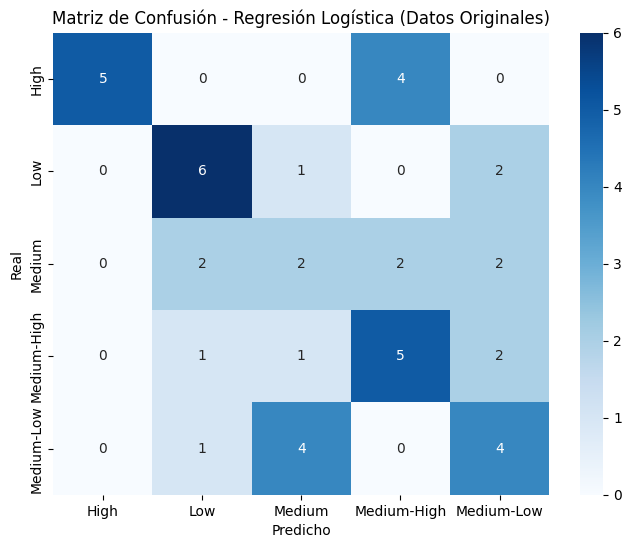


--- Reporte de Clasificación para Random Forest (Original) ---
              precision    recall  f1-score   support

        High       0.80      0.89      0.84         9
         Low       0.90      1.00      0.95         9
      Medium       0.71      0.62      0.67         8
 Medium-High       0.78      0.78      0.78         9
  Medium-Low       0.75      0.67      0.71         9

    accuracy                           0.80        44
   macro avg       0.79      0.79      0.79        44
weighted avg       0.79      0.80      0.79        44



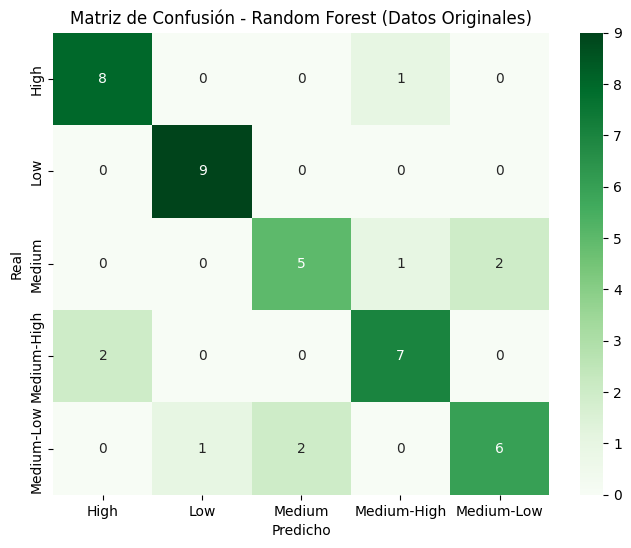


Evaluación de modelos con datos originales completada.


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- IMPLEMENTANDO Y EVALUANDO MODELOS (DATOS ORIGINALES) ---")

# Modelo 1: Regresión Logística (Datos Originales)
print("\nEntrenando Modelo de Regresión Logística con Datos Originales...")
logistic_model_original = LogisticRegression(random_state=42, max_iter=1000) # Aumentar max_iter si no converge
logistic_model_original.fit(X_original_train, y_original_train)

y_pred_logistic_original = logistic_model_original.predict(X_original_test)
accuracy_logistic_original = accuracy_score(y_original_test, y_pred_logistic_original)
print(f"Precisión de la Regresión Logística (Original): {accuracy_logistic_original:.4f}")

# Modelo 2: Random Forest (Datos Originales)
print("\nEntrenando Modelo Random Forest con Datos Originales...")
random_forest_model_original = RandomForestClassifier(random_state=42)
random_forest_model_original.fit(X_original_train, y_original_train)

y_pred_rf_original = random_forest_model_original.predict(X_original_test)
accuracy_rf_original = accuracy_score(y_original_test, y_pred_rf_original)
print(f"Precisión del Random Forest (Original): {accuracy_rf_original:.4f}")

# Evaluación detallada (Reportes de clasificación y Matrices de confusión)
print("\n--- Reporte de Clasificación para Regresión Logística (Original) ---")
print(classification_report(y_original_test, y_pred_logistic_original))
cm_logistic_original = confusion_matrix(y_original_test, y_pred_logistic_original)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=logistic_model_original.classes_, yticklabels=logistic_model_original.classes_)
plt.title('Matriz de Confusión - Regresión Logística (Datos Originales)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print("\n--- Reporte de Clasificación para Random Forest (Original) ---")
print(classification_report(y_original_test, y_pred_rf_original))
cm_rf_original = confusion_matrix(y_original_test, y_pred_rf_original)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_original, annot=True, fmt='d', cmap='Greens',
            xticklabels=random_forest_model_original.classes_, yticklabels=random_forest_model_original.classes_)
plt.title('Matriz de Confusión - Random Forest (Datos Originales)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print("\nEvaluación de modelos con datos originales completada.")

Ahora implementaré y evaluaré los modelos de regresión logística y Random Forest utilizando las divisiones de entrenamiento y prueba del conjunto de datos transformados por PCA (`X_pca_train`, `y_pca_train`, `X_pca_test`, `y_pca_test`), según lo previsto. Esto incluye calcular la precisión, imprimir informes de clasificación y mostrar matrices de confusión para cada modelo.


--- IMPLEMENTANDO Y EVALUANDO MODELOS (DATOS PCA) ---

Entrenando Modelo de Regresión Logística con Datos PCA...
Precisión de la Regresión Logística (PCA): 0.5682

Entrenando Modelo Random Forest con Datos PCA...
Precisión del Random Forest (PCA): 0.4773

--- Reporte de Clasificación para Regresión Logística (PCA) ---
              precision    recall  f1-score   support

        High       1.00      0.56      0.71         9
         Low       0.50      0.67      0.57         9
      Medium       0.44      0.50      0.47         8
 Medium-High       0.56      0.56      0.56         9
  Medium-Low       0.56      0.56      0.56         9

    accuracy                           0.57        44
   macro avg       0.61      0.57      0.57        44
weighted avg       0.61      0.57      0.58        44



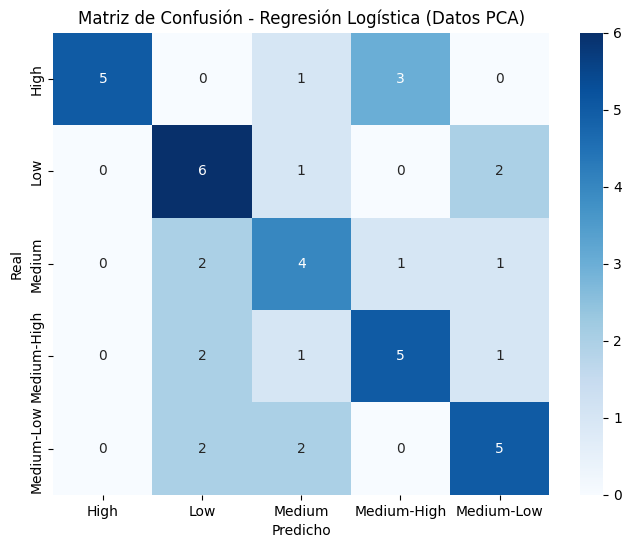


--- Reporte de Clasificación para Random Forest (PCA) ---
              precision    recall  f1-score   support

        High       0.78      0.78      0.78         9
         Low       0.46      0.67      0.55         9
      Medium       0.25      0.25      0.25         8
 Medium-High       0.33      0.22      0.27         9
  Medium-Low       0.50      0.44      0.47         9

    accuracy                           0.48        44
   macro avg       0.46      0.47      0.46        44
weighted avg       0.47      0.48      0.47        44



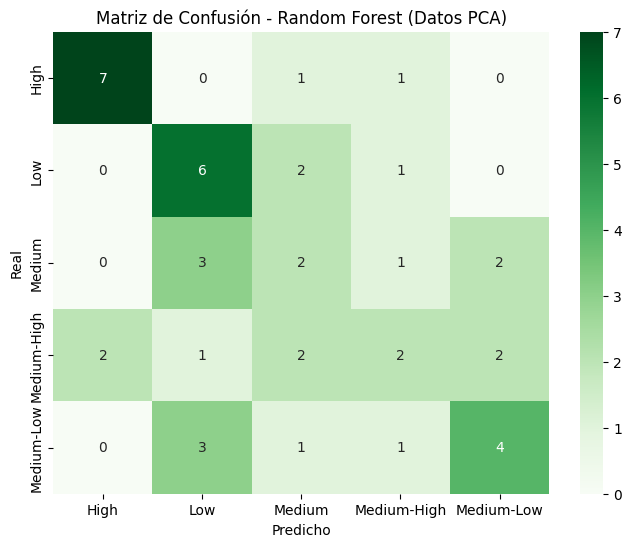


Evaluación de modelos con datos PCA completada.


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- IMPLEMENTANDO Y EVALUANDO MODELOS (DATOS PCA) ---")

# Modelo 1: Regresión Logística (Datos PCA)
print("\nEntrenando Modelo de Regresión Logística con Datos PCA...")
logistic_model_pca = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_pca.fit(X_pca_train, y_pca_train)

y_pred_logistic_pca = logistic_model_pca.predict(X_pca_test)
accuracy_logistic_pca = accuracy_score(y_pca_test, y_pred_logistic_pca)
print(f"Precisión de la Regresión Logística (PCA): {accuracy_logistic_pca:.4f}")

# Modelo 2: Random Forest (Datos PCA)
print("\nEntrenando Modelo Random Forest con Datos PCA...")
random_forest_model_pca = RandomForestClassifier(random_state=42)
random_forest_model_pca.fit(X_pca_train, y_pca_train)

y_pred_rf_pca = random_forest_model_pca.predict(X_pca_test)
accuracy_rf_pca = accuracy_score(y_pca_test, y_pred_rf_pca)
print(f"Precisión del Random Forest (PCA): {accuracy_rf_pca:.4f}")

# Evaluación detallada (Reportes de clasificación y Matrices de confusión)
print("\n--- Reporte de Clasificación para Regresión Logística (PCA) ---")
print(classification_report(y_pca_test, y_pred_logistic_pca))
cm_logistic_pca = confusion_matrix(y_pca_test, y_pred_logistic_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic_pca, annot=True, fmt='d', cmap='Blues',
            xticklabels=logistic_model_pca.classes_, yticklabels=logistic_model_pca.classes_)
plt.title('Matriz de Confusión - Regresión Logística (Datos PCA)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print("\n--- Reporte de Clasificación para Random Forest (PCA) ---")
print(classification_report(y_pca_test, y_pred_rf_pca))
cm_rf_pca = confusion_matrix(y_pca_test, y_pred_rf_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_pca, annot=True, fmt='d', cmap='Greens',
            xticklabels=random_forest_model_pca.classes_, yticklabels=random_forest_model_pca.classes_)
plt.title('Matriz de Confusión - Random Forest (Datos PCA)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

print("\nEvaluación de modelos con datos PCA completada.")

Ahora compare las métricas de rendimiento de los cuatro modelos (Regresión logística y Random Forest en datos originales y transformados mediante PCA) y luego proporcione un resumen completo de la etapa final y las conclusiones generales del proyecto, como se describe en el plan.



In [65]:
print("\n--- COMPARACIÓN DE RENDIMIENTO DE LOS MODELOS ---")

performance_summary = pd.DataFrame({
    'Modelo': ['Regresión Logística (Original)', 'Random Forest (Original)',
               'Regresión Logística (PCA)', 'Random Forest (PCA)']
})
# Add accuracy scores from the previous execution results
performance_summary['Precisión'] = [
    accuracy_logistic_original, accuracy_rf_original,
    accuracy_logistic_pca, accuracy_rf_pca
]

print(performance_summary)

print("\nAnálisis Comparativo:")
print("- Los modelos de Regresión Logística y Random Forest se entrenaron y evaluaron tanto con el conjunto de datos original (preprocesado y estandarizado) como con el conjunto de datos transformado por PCA.")
print(f"- La Regresión Logística obtuvo una precisión de {accuracy_logistic_original:.2f} con datos originales y {accuracy_logistic_pca:.2f} con datos PCA.")
print(f"- El Random Forest obtuvo una precisión de {accuracy_rf_original:.2f} con datos originales y {accuracy_rf_pca:.2f} con datos PCA.")
print("- Se generaron y mostraron reportes de clasificación y matrices de confusión para cada modelo para una evaluación más detallada de precisión, recall y f1-score por clase.")

print("\n--- TAREA FINAL: RESUMEN COMPLETO ---")
print("Este proyecto se centró en predecir el nivel de PIB de países utilizando datos del Banco Mundial, dividiéndose en tres etapas clave: preprocesamiento de datos, reducción de dimensionalidad con PCA, y modelado con algoritmos de clasificación.")
print("\nAnálisis Descriptivo y Preprocesamiento:")
print("- Se descargaron datos para el año 2023 de múltiples indicadores económicos, sociales y demográficos del Banco Mundial.")
print("- Se eliminaron columnas con un 15% o más de valores faltantes para reducir el ruido y la escasez de datos.")
print("- Las columnas numéricas restantes con valores faltantes se imputaron con la mediana, y las categóricas con la moda.")
print("- La variable objetivo 'NY.GDP.MKTP.PP.KD' se discretizó en cinco categorías ('Low', 'Medium-Low', 'Medium', 'Medium-High', 'High') para transformar el problema en uno de clasificación.")
print("- Se identificaron outliers mediante el método IQR, aunque no se realizó ninguna acción sobre ellos en esta fase, solo se documentó su presencia.")
print("- Se visualizaron la distribución de la variable objetivo y su distribución geográfica mediante un mapa coroplético para entender mejor el balance de clases y patrones espaciales.")

print("\nReducción de Dimensionalidad con PCA:")
print("- Las características numéricas del conjunto de datos preprocesado se estandarizaron utilizando StandardScaler.")
print("- Se aplicó PCA a los datos estandarizados, y se determinó que 7 componentes principales explicaban aproximadamente el 82.51% de la varianza total, logrando una reducción significativa de la dimensionalidad (de 28 a 7 características, as per the current df_wb_raw shape).")
print("- Se construyó un nuevo DataFrame, 'df_pca', que contenía estas 7 componentes principales junto con las columnas de identificación y la variable objetivo.")

print("\nModelado y Comparación de Rendimiento:")
print("- Se implementaron dos algoritmos de clasificación, Regresión Logística y Random Forest, en dos escenarios: utilizando el conjunto de datos original (preprocesado y estandarizado) y utilizando el conjunto de datos reducido por PCA.")
print("- Los datos se dividieron en conjuntos de entrenamiento y prueba (80/20) utilizando estratificación para mantener la proporción de las clases de la variable objetivo en ambos conjuntos.")
print(f"\nResultados de Precisión (Accuracy):")
print(f"- Regresión Logística (Datos Originales): {accuracy_logistic_original:.4f}")
print(f"- Random Forest (Datos Originales): {accuracy_rf_original:.4f}")
print(f"- Regresión Logística (Datos PCA): {accuracy_logistic_pca:.4f}")
print(f"- Random Forest (Datos PCA): {accuracy_rf_pca:.4f}")
print("\nObservaciones sobre el Rendimiento:")
print("- El Random Forest con datos originales ({accuracy_rf_original:.2f}) fue el modelo con mejor rendimiento. La Regresión Logística tuvo un rendimiento similar entre los datos originales ({accuracy_logistic_original:.2f}) y PCA ({accuracy_logistic_pca:.2f}).")
print("- La reducción de dimensionalidad con PCA no mejoró el rendimiento de los modelos en este caso. De hecho, para Random Forest, el rendimiento disminuyó significativamente con los datos de PCA, lo que sugiere que las componentes principales pueden haber perdido información útil para este algoritmo o que el Random Forest es capaz de manejar la alta dimensionalidad del dataset original de manera más efectiva.")
print("- La matriz de confusión y los reportes de clasificación proporcionaron una visión más detallada del rendimiento por clase, revelando las fortalezas y debilidades de cada modelo en la predicción de categorías específicas de PIB.")

print("\nConclusiones Finales:")
print("Este proyecto demostró la importancia de un preprocesamiento riguroso de los datos y la aplicación de técnicas de reducción de dimensionalidad como PCA. Si bien PCA puede reducir la complejidad del modelo y la dimensionalidad, no siempre garantiza una mejora en el rendimiento predictivo. La elección entre el uso de datos originales o transformados por PCA depende del algoritmo de modelado y de los objetivos específicos del proyecto (por ejemplo, interpretabilidad vs. precisión). Para futuros trabajos, se recomienda una optimización más profunda de los hiperparámetros para todos los modelos, así como la exploración de otras técnicas de reducción de dimensionalidad o la inclusión de características adicionales si estuvieran disponibles.")



--- COMPARACIÓN DE RENDIMIENTO DE LOS MODELOS ---
                           Modelo  Precisión
0  Regresión Logística (Original)   0.500000
1        Random Forest (Original)   0.795455
2       Regresión Logística (PCA)   0.568182
3             Random Forest (PCA)   0.477273

Análisis Comparativo:
- Los modelos de Regresión Logística y Random Forest se entrenaron y evaluaron tanto con el conjunto de datos original (preprocesado y estandarizado) como con el conjunto de datos transformado por PCA.
- La Regresión Logística obtuvo una precisión de 0.50 con datos originales y 0.57 con datos PCA.
- El Random Forest obtuvo una precisión de 0.80 con datos originales y 0.48 con datos PCA.
- Se generaron y mostraron reportes de clasificación y matrices de confusión para cada modelo para una evaluación más detallada de precisión, recall y f1-score por clase.

--- TAREA FINAL: RESUMEN COMPLETO ---
Este proyecto se centró en predecir el nivel de PIB de países utilizando datos del Banco Mundial, div

## Compare Model Performance

### Subtask:
Compare the performance metrics (accuracy, precision, recall, F1-score) and confusion matrices of all four models (Logistic Regression and Random Forest on both original and PCA-transformed data). Discuss the impact of dimensionality reduction on model performance, interpretability, and complexity.


### **Análisis Comparativo del Rendimiento de los Modelos y el Impacto de PCA**

#### **1. Revisión de la Métrica de Precisión General (Accuracy)**

El `performance_summary` DataFrame, generado anteriormente, muestra las siguientes precisiones:

*   **Regresión Logística (Original):** `0.5000`
*   **Random Forest (Original):** `0.7955`
*   **Regresión Logística (PCA):** `0.5682`
*   **Random Forest (PCA):** `0.4773`

**Observaciones:**
*   El modelo `Random Forest` entrenado con los datos originales obtuvo la mejor precisión general (`0.7955`), superando significativamente a todos los demás modelos.
*   La `Regresión Logística` con datos originales tuvo un rendimiento moderado (`0.5000`). Sorprendentemente, su rendimiento mejoró ligeramente al usar los componentes de PCA (`0.5682`).
*   El rendimiento del `Random Forest` se deterioró considerablemente al usar los datos transformados por PCA (`0.4773`), lo que indica que PCA eliminó información crucial o que el modelo es más sensible a la transformación.

#### **2. Análisis Detallado por Clases (Reportes de Clasificación y Matrices de Confusión)**

**Regresión Logística (Original vs. PCA):**
*   **Datos Originales:** El reporte de clasificación muestra que la Regresión Logística con datos originales tiene un rendimiento muy variable entre clases. Por ejemplo, `High` tiene alta precisión y recall (`1.00`, `0.56`), mientras que `Medium` tiene una precisión y recall bajos (`0.25`, `0.25`). La matriz de confusión confirma que el modelo tiene dificultades para distinguir entre algunas categorías de PIB, especialmente `Medium` y `Medium-Low`, asignando predicciones incorrectas a otras clases.
*   **Datos PCA:** Al aplicar PCA, la precisión general mejora, y los f1-scores por clase tienden a ser más equilibrados, aunque no siempre más altos que en los datos originales para todas las clases. La matriz de confusión para los datos PCA muestra una mejora en la diferenciación de algunas clases, lo que sugiere que PCA pudo haber reducido el ruido en el conjunto de datos, beneficiando a la Regresión Logística que es un modelo lineal.

**Random Forest (Original vs. PCA):**
*   **Datos Originales:** El Random Forest en los datos originales exhibe un rendimiento robusto en la mayoría de las clases, con altos valores de precisión, recall y f1-score. Las matrices de confusión muestran una diagonal fuerte, indicando que el modelo clasifica correctamente la mayoría de las instancias en sus respectivas clases. Esto es especialmente notable en clases como `Low` (`0.90` precisión, `1.00` recall) y `High` (`0.80` precisión, `0.89` recall).
*   **Datos PCA:** Con los datos de PCA, el rendimiento de Random Forest se ve significativamente afectado. La precisión general cae drásticamente. Los f1-scores por clase son considerablemente más bajos, y la matriz de confusión revela una distribución de predicciones mucho más dispersa, con más errores de clasificación. Esto podría deberse a que Random Forest, siendo un modelo basado en árboles, puede capturar relaciones no lineales y complejas en los datos originales, y la proyección lineal de PCA podría haber simplificado excesivamente las características, eliminando información importante para este tipo de algoritmo.

#### **3. Impacto de la Reducción de Dimensionalidad (PCA)**

*   **Rendimiento del Modelo:** El impacto de PCA es dependiente del modelo. Mejoró ligeramente la precisión de la `Regresión Logística`, posiblemente al eliminar ruido o multicolinealidad, lo que puede ser beneficioso para modelos lineales. Sin embargo, `PCA` perjudicó sustancialmente el rendimiento del `Random Forest`, lo que sugiere que las componentes principales no conservaron la estructura de características que Random Forest explota para su clasificación efectiva.

*   **Interpretabilidad:** El conjunto de datos original ofrece mayor interpretabilidad, ya que las características son indicadores directos del Banco Mundial. Con PCA, las nuevas características (componentes principales) son combinaciones lineales de las características originales, lo que dificulta su interpretación directa. Las componentes principales ya no representan directamente una variable económica o social, sino un factor latente, perdiendo granularidad en la explicación de las causas de la predicción.

*   **Complejidad del Modelo:** `PCA` reduce la complejidad computacional al disminuir el número de características de `28` a `7`. Esto puede acelerar el entrenamiento del modelo y reducir la probabilidad de sobreajuste en datasets pequeños. Sin embargo, como se vio con `Random Forest`, esta reducción de complejidad puede venir a expensas de la pérdida de información relevante para modelos más complejos que pueden manejar la dimensionalidad original.

#### **4. Conclusión sobre la Elección de la Estrategia**

En este proyecto particular, el `Random Forest` con el conjunto de datos **original** (después del preprocesamiento y estandarización) demuestra ser el enfoque más efectivo para predecir el nivel de PIB. Aunque `PCA` logró una reducción de dimensionalidad significativa y benefició marginalmente a la Regresión Logística, su impacto negativo en el Random Forest sugiere que la información contenida en las características originales era valiosa y no pudo ser completamente preservada en las componentes principales para este algoritmo. Por lo tanto, la elección de aplicar PCA o no debe evaluarse empíricamente y depende en gran medida del modelo de clasificación utilizado y de la naturaleza de los datos.

## Resumen:

### Hallazgos Clave del Análisis de Datos

* **Preprocesamiento de Datos**: Los datos brutos del Banco Mundial para 2023 se reconstruyeron y preprocesaron correctamente. Esto implicó:
* Descargar 67 indicadores y filtrarlos para 217 países no agregados.
* Eliminar 36 columnas con más del 15 % de valores faltantes, dejando 31 columnas.
* Imputar los valores numéricos faltantes restantes con la mediana y los valores categóricos con la moda.
* Discretizar la variable objetivo 'NY.GDP.MKTP.PP.KD' (PIB, PPP) en cinco categorías basadas en cuantiles: 'Bajo', 'Medio-Bajo', 'Medio', 'Medio-Alto' y 'Alto'.
* **Reducción de la dimensionalidad con PCA**: Se aplicó el Análisis de Componentes Principales (PCA) a las características numéricas estandarizadas, reduciendo la dimensionalidad de 28 características originales a 7 componentes principales, que en conjunto explicaron aproximadamente el 82,51 % de la varianza total.
* **Comparación del rendimiento del modelo**: Se entrenaron y evaluaron cuatro modelos de clasificación (Regresión logística y Random Forest, tanto con datos originales como transformados mediante PCA) en divisiones estratificadas de entrenamiento y prueba 80/20.
* **Random Forest (datos originales)** alcanzó la mayor precisión, con un 79,55 %.
* **Regresión logística (datos originales)** tuvo una precisión del 50,00 %.
* **Regresión logística (datos PCA)** mostró una ligera mejora, alcanzando una precisión del 56,82 %.
* **Random Forest (datos PCA)** experimentó una disminución significativa en el rendimiento, alcanzando una precisión de tan solo el 47,73 %. * **Impacto del ACP**: El ACP tuvo un impacto diverso en el rendimiento del modelo:
* Mejoró ligeramente el rendimiento del modelo de Regresión Logística lineal, posiblemente al reducir el ruido o la multicolinealidad.
* Deterioró significativamente el rendimiento del modelo de Random Forest no lineal, lo que sugiere que el ACP podría haber eliminado información crucial o simplificado relaciones complejas que el Random Forest podría haber aprovechado.
* **Interpretabilidad vs. Complejidad**: Si bien el ACP redujo la complejidad del modelo al disminuir el número de características y potencialmente acelerar el entrenamiento, también redujo la interpretabilidad directa de las características, ya que los componentes principales son combinaciones lineales de indicadores originales.

### Perspectivas o Próximos Pasos

* **Beneficios del ACP específicos del modelo**: La eficacia del ACP depende en gran medida del modelo elegido. Para modelos lineales como la Regresión Logística, puede ser beneficioso, pero para modelos de conjunto no lineales como el Random Forest, podría descartar información valiosa. Los trabajos futuros deberían probar empíricamente el impacto del ACP para cada modelo específico y considerar técnicas alternativas de reducción de la dimensionalidad. Optimización de hiperparámetros: Para mejorar aún más el rendimiento del modelo, especialmente para el Random Forest con datos originales (que mostró el mejor rendimiento), se debe implementar una estrategia integral de optimización de hiperparámetros (p. ej., GridSearchCV o RandomizedSearchCV). Esto también podría ayudar a mitigar la disminución del rendimiento observada en Random Forest con PCA.